In [1]:
using CairoMakie
using GeoMakie
using NCDatasets
using Statistics
using GLM
using CSV
using Polynomials
using ShiftedArrays
using TypedTables
using DataFrames

In [2]:
#import Pkg
#Pkg.add("TypedTables")

In [3]:
function find_best_fit(xvals,yvals)
# taken from julia for Data Science tutorial by Dr. Huda Nassar
  meanx = mean(xvals)
  meany = mean(yvals)
  stdx  = std(xvals)
  stdy  = std(yvals)
  r     = cor(xvals,yvals)
  a     = r*stdy/stdx
  b     = meany - a*meanx
  return a,b
end


find_best_fit (generic function with 1 method)

In [4]:
path="/Users/C823281551/data/ERA5/"
filein1  = path*"era5_sst_1979th2024_OctNov_360x180.nc"                                             
filein1b = path*"era5_sst_1979th2024_OctNov.nc"
filein   = path*"MPI_ERA5_OctNov_full_output.nc" 

"/Users/C823281551/data/ERA5/MPI_ERA5_OctNov_full_output.nc"

In [5]:
tag = "ERA5"
data1  = NCDataset(filein1)
data1b = NCDataset(filein1b)
data   = NCDataset(filein)

#lat = data["latitude"]
#lon = data["longitude"]
lat = data["lat"]
lon = data["lon"]
tme = data["valid_time"]
latb = data1b["latitude"]
lonb = data1b["longitude"]

dim_var  = data1["sst"]
dim_varb = data1b["sst"]

timeAxis1 = collect(1:1:92);
#timeAx = convert(Float32, timeAxis1);
timeAx = Float32.(timeAxis1);
 
sst_var = data["sst"];
sst_var_b = data1b["sst"];
pi_var  = data["vmax"];
dims    = size(dim_var)
dim_high= size(dim_varb)

# relative humidity
level=2 # level 2 should correspond to the 700 hPa pressure level. 
lat1 = 1
lat2 = 180


180

In [6]:
level=2 # level 2 should correspond to the 700 hPa pressure level. 
lat1 = 1
lat2 = 180

agrid  = Array{Union{Missing, Float64}, 2}(undef, dims[1], dims[2])
bgrid  = Array{Union{Missing, Float64}, 2}(undef, dims[1], dims[2])

for i in 1:dims[1]
    for j in 1:dims[2]
        agrid[i,j],bgrid[i,j] = find_best_fit(timeAxis1[:],sst_var[i,j,:])
    end
end



In [7]:
function local_fig(inpv,d1,d2,tit,levs)
    f2 = Figure(;
        figure_padding=(5,5,10,10),
        backgroundcolor=:white,                                                                     
        size=(900,700),                                                                             
        )   
    ax = GeoAxis(f2[1,1];
        aspect = 3,
        dest="+proj=latlon",                                                                        
        xticks = -160:20:180,                                                                       
        yticks = -30:20:30,                                                                         
        xlabel="longitude",
        ylabel="latitude",
        limits=(-160,180,-30,30),
        title=tit, 
        xticklabelsize = 14, # 14,16 are pretty reasonable sizes                                    
        yticklabelsize = 14, # 22 used for 8 panel figure that needs larger font                    
        )                                                                                           
        bb = contourf!(ax, d1, d2, inpv,                                                            
             levels = levs,
             #colormap = :batlow,
             #colormap = :bam, # default for shear plot (greens and pinks)
             #colormap = :seismic, # colors are a bit harsh                                         
             colormap = :vik, # default for redish bluish for relative SST                          
             #colormap = :BrBg, # better for RH  browns and greens                                  
             #colormap = :roma,
             extendlow = :auto, extendhigh = :auto                                                  
        )       
        lines!(ax, GeoMakie.coastlines(), color = :black, linewidth=0.75)                           
        Colorbar(f2[1,2], bb)                                                                       
    return f2                                                                                       
end     


local_fig (generic function with 1 method)

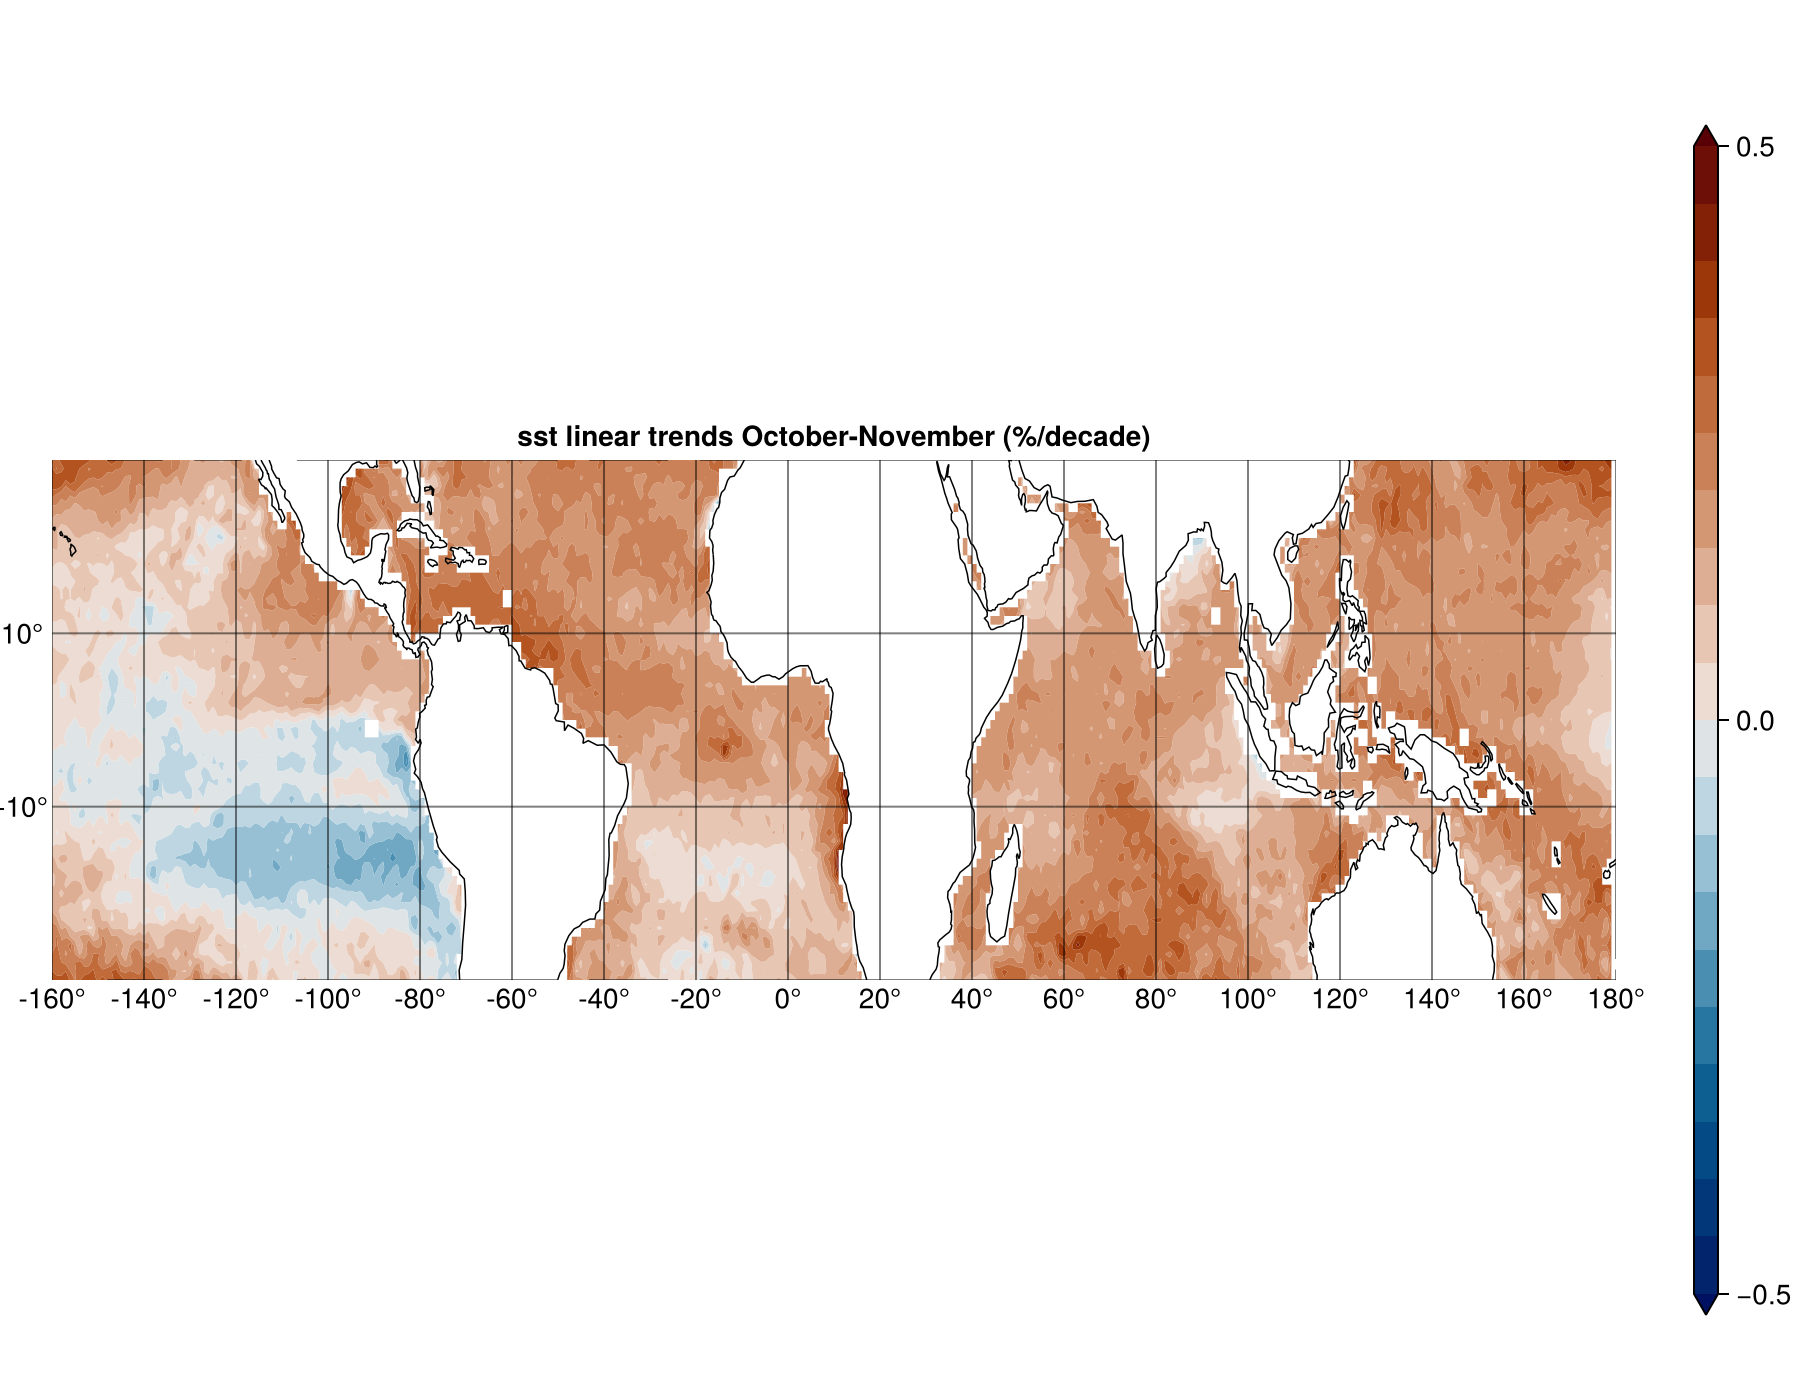

In [8]:
levs = range(-0.5, 0.5, length = 21)
local_fig(agrid.*20,lon,lat,"sst linear trends October-November (%/decade)",levs)
#save("era5_sst_LinTrend_OctThNov_ptest.png", blah, px_per_unit=6.0)

In [9]:
size(sst_var)

(360, 180, 92)

In [10]:
Y1 = sst_var[180,90,:];
Y2 = sst_var[100,80,:];
Y3 = sst_var[1,90,:];
# first convert sst_var to Float64, then run regression on every grid point
#sst_var64 = Float64.(sst_var) # why doesn't this work? 

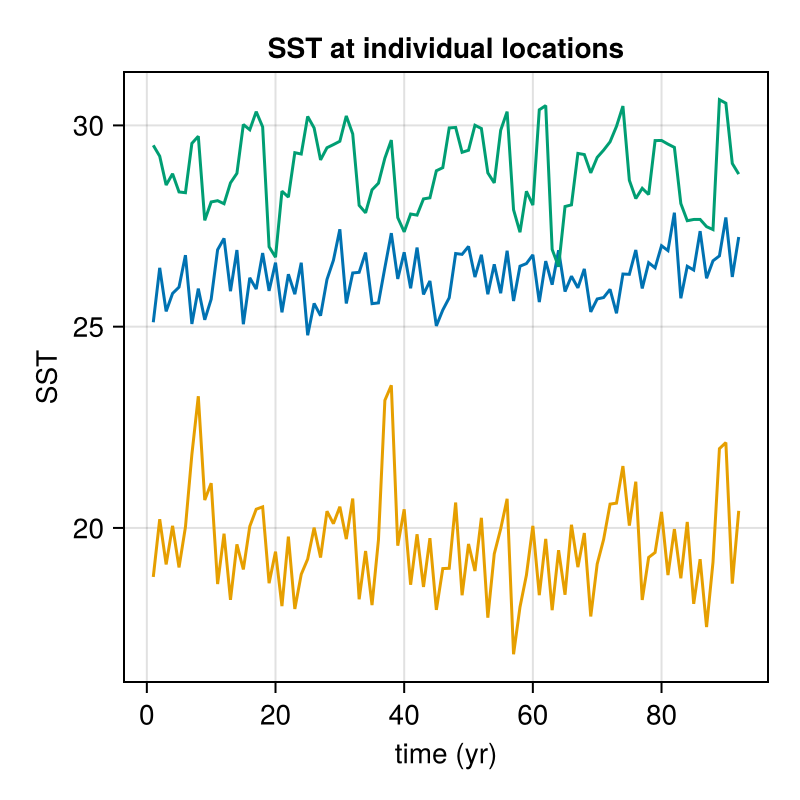

In [11]:
fig2 = Figure(;
    size = (400,400),
    )
ax = Axis(fig2[1,1];
    xlabel = "time (yr)",
    ylabel = "SST",
    title  = "SST at individual locations")
#lines!(C,ts_roni_sm, linestyle = :solid)
lines!(timeAxis1[:],sst_var[180,90,:])
lines!(timeAxis1[:],sst_var[100,80,:])
lines!(timeAxis1[:],sst_var[1,90,:])
#plot!(C,ts_roni_sm) # plots the time series using dots for the data points. 
#plot!(C,forNew)
fig2

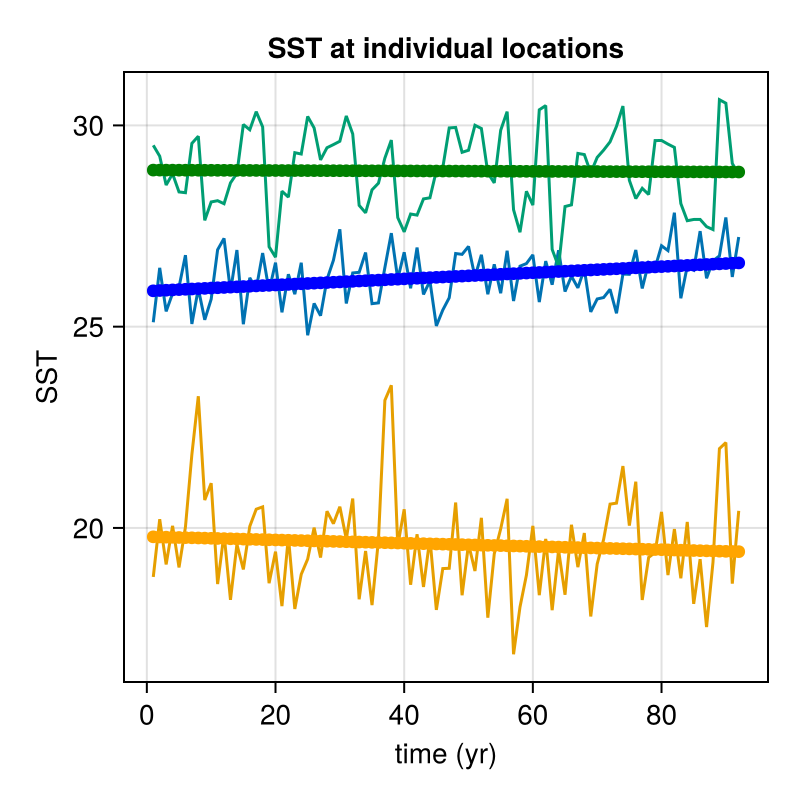

In [12]:
# generalize this cell for each grid point...

X = timeAx
X2 = Float64.(timeAx);

#Y2 = sst_var[100,80,:]
Y164 = Float64.(Y1)
Y264 = Float64.(Y2)
Y364 = Float64.(Y3)

t1 = Table(X = X2, Y = Y164);
t2 = Table(X = X2, Y = Y264);
t3 = Table(X = X2, Y = Y364);

ols1 = lm(@formula(Y ~ X), t1)
ols2 = lm(@formula(Y ~ X), t2)
ols3 = lm(@formula(Y ~ X), t3)

    plot!(X, predict(ols1), color = :blue)
    plot!(X, predict(ols2), color = :orange)
    plot!(X, predict(ols3), color = :green)

fig2

In [58]:
# save the pvalue to a variable
pvalgrid  = Array{Union{Missing, Float64}, 2}(undef, dims[1], dims[2])
#Yind      = Array{Union{Missing, Float64}, 1}(undef, dims[3])
#testVals = coeftable(ols1)
#pvalgrid[1,1] = testVals.cols[4][2] # we want to fill this whole grid with a field of pvals...

for i in 1:360 # dims[1] longitudes
    for j in 1:180 # dims[2] latitudes
        #Yind      = Array{Union{Missing, Float64}, 1}(undef, dims[3])
        Yind = sst_var[i,j,:];
        #Yind  = sst_var[1 time series]
        if any(ismissing, Yind)
            println("missing value found ")
        else
        #Ytemp = Float64.(Yind)
        # need to somehow check if Yind contains missing data, and if so, then don't proceed to the lm step.  
            println("missing value not found ")
            Ytemp = Float64.(Yind)
            tab   = Table(X = X2, Y = Ytemp);
            ols_temp = lm(@formula(Y ~ X), tab)
            testVals = coeftable(ols_temp)
            #pvaltemp = testVals.cols[4][2]
            pvalgrid[i,j] = testVals.cols[4][2]
        end
    end
end
# now extract the p-value 

missing value found 
missing value found 
missing value found 
missing value found 
missing value found 
missing value found 
missing value found 
missing value found 
missing value found 
missing value found 
missing value found 
missing value found 
missing value found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
mi

Excessive output truncated after 524294 bytes.

missing value found 
missing value found 
missing value found 
missing value found 
missing value found 
missing value found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing value not found 
missing

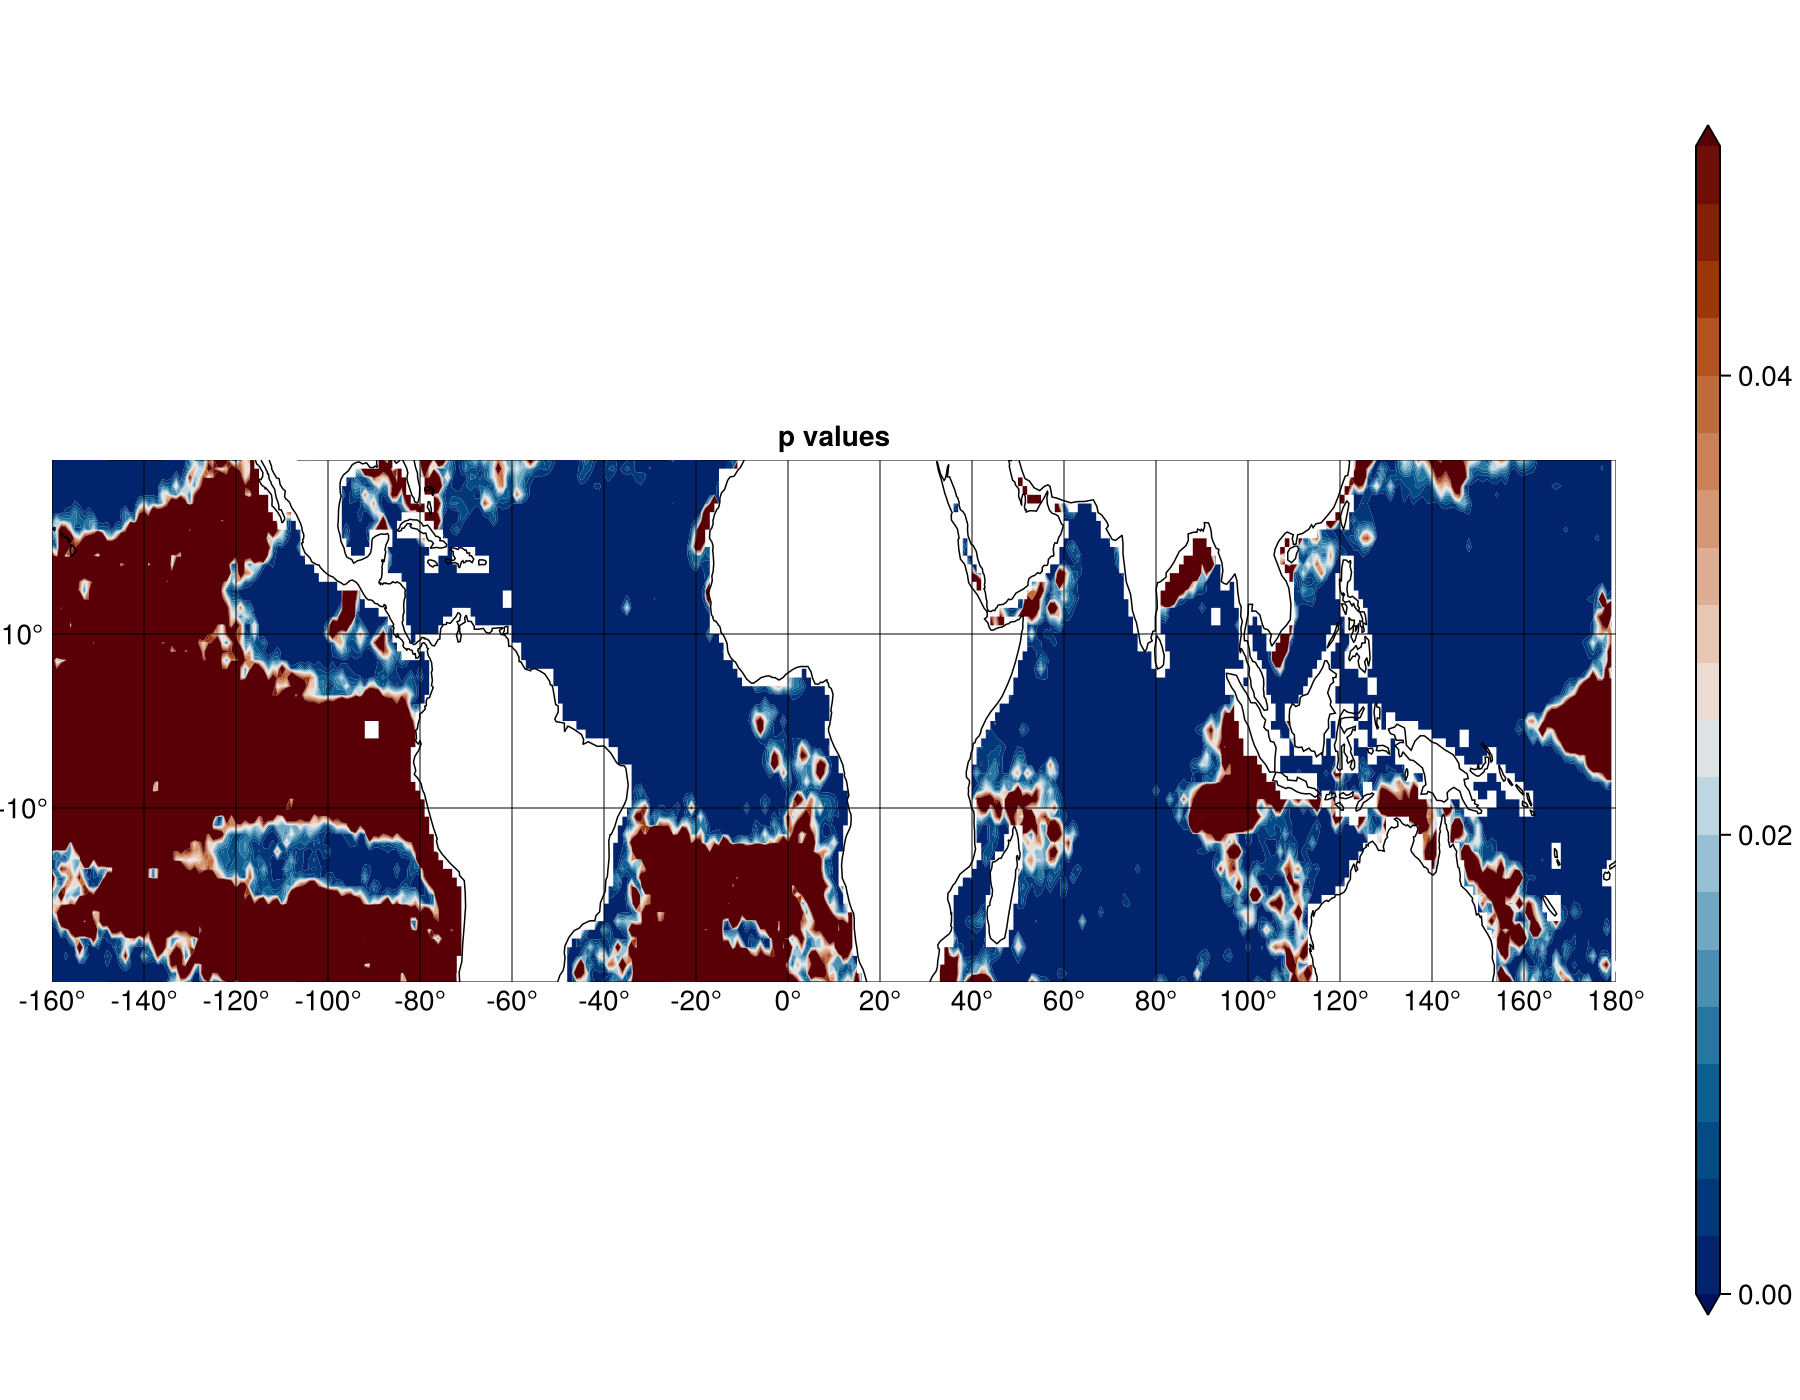

In [68]:
levs = range(0.0, 0.05, length = 21)
local_fig(pvalgrid,lon,lat,"p values",levs)

In [64]:
i = 1; j = 1
Yind = sst_var[i,j,:];
#Ytemp = Float64.(Yind)
dims[3]
#ismissing.(Yind)
minimum(skipmissing(pvalgrid))

6.90374619231552e-23

In [70]:
# blue linke, should be decent positive trend; 0.2% chance the trend is not different from zero?  or 0.2% change
# we see the given trend 'by chance'.
ols1 = lm(@formula(Y ~ X), t1)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
───────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error       t  Pr(>|t|)    Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────
(Intercept)  25.8826      0.130473    198.38    <1e-99  25.6234      26.1418
X             0.00760994  0.00243651    3.12    0.0024   0.00276939   0.0124505
───────────────────────────────────────────────────────────────────────────────

In [71]:
testVals = coeftable(ols1)
givein = testVals.cols[4][2] #
#pvalgrid[1,1]

0.002405941724824299

In [72]:
armsOcean = testVals.cols[5][2]

0.002769386851675413

In [74]:
testVals = coeftable(ols1)
if testVals.cols[4][2] <= testVals.cols[5][2]
    print("so cold and so sweet")
else
    print("giving up")
end

so cold and so sweet

In [75]:
# orange line, should be slightly negative trend; 41% chance the trend is not different from zero?
ols2 = lm(@formula(Y ~ X), t2)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      t  Pr(>|t|)  Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  19.7834      0.261688    75.60    <1e-82  19.2636    20.3033
X            -0.00404738  0.00488689  -0.83    0.4097  -0.013756   0.00566128
─────────────────────────────────────────────────────────────────────────────

In [76]:
testVals = coeftable(ols2)
if testVals.cols[4][2] <= testVals.cols[5][2]
    print("so cold and so sweet")
else
    print("giving up")
end

giving up

In [77]:
# green line, very slight negative trend; 89% change the trend is not different from zero?
ols3 = lm(@formula(Y ~ X), t3)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                    Coef.  Std. Error       t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)  28.8897       0.209431    137.94    <1e-99  28.4736      29.3057
X            -0.000525565  0.00391101   -0.13    0.8934  -0.00829546   0.00724433
─────────────────────────────────────────────────────────────────────────────────

In [ ]:
testVals = coeftable(ols3)
if testVals.cols[4][2] <= testVals.cols[5][2]
    print("so cold and so sweet")
    # field values = 1, indicating the p-value criterion has been met
else
    print("giving up")
    # field values = 0
end

giving up

In [20]:
# data = DataFrame(y = rand(rng, 100), x = categorical(repeat([1, 2, 3, 4], 25)));
testV = sst_var[100,80,:];
#data = DataFrame(y = sst_var[100,80,:], x = timeAx, 92);
data1 = DataFrame(y = testV, x = timeAx)
ols2 = lm(@formula(y ~ x), data1)

LoadError: MethodError: no method matching delbeta!(::GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}, ::Vector{Float32})
The function `delbeta!` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  delbeta!([91m::GLM.SparsePredChol{T}[39m, ::Vector{T}) where T
[0m[90m   @[39m [35mGLM[39m [90m~/.julia/packages/GLM/vM20T/src/[39m[90m[4mlinpred.jl:220[24m[39m
[0m  delbeta!([91m::GLM.SparsePredChol{T}[39m, ::Vector{T}, [91m::Vector{T}[39m) where T
[0m[90m   @[39m [35mGLM[39m [90m~/.julia/packages/GLM/vM20T/src/[39m[90m[4mlinpred.jl:213[24m[39m
[0m  delbeta!(::GLM.DensePredChol{T, <:LinearAlgebra.CholeskyPivoted}, [91m::Vector{T}[39m, [91m::Vector{T}[39m) where T<:Union{Float32, Float64}
[0m[90m   @[39m [35mGLM[39m [90m~/.julia/packages/GLM/vM20T/src/[39m[90m[4mlinpred.jl:159[24m[39m
[0m  ...


In [57]:
testVals = coeftable(ols1)

|             |       Coef. | Std. Error |      t | Pr(>|t|) |   Lower 95% |  Upper 95% |
|:------------|------------:|-----------:|-------:|:---------|:------------|-----------:|
| (Intercept) | 25.8826     | 0.130473   | 198.38 |   <1e-99 | 25.6234     | 26.1418 |
| X           |  0.00760994 | 0.00243651 |   3.12 |   0.0024 |  0.00276939 |  0.0124505 |

In [68]:
pval = testVals.cols[4][2]

0.002405941724824299

### test regression method from Tutorial.    I can't get the glm model to work on the code above, so perhaps testing it with code that worked in the doggoTut tutorial will help me to trouble shoot.  

In [25]:
data = CSV.File("doggoTut/dataDownloaded.csv")

47-element CSV.File:
 CSV.Row: (size = 2104, price = 399900)
 CSV.Row: (size = 1600, price = 329900)
 CSV.Row: (size = 2400, price = 369000)
 CSV.Row: (size = 1416, price = 232000)
 CSV.Row: (size = 3000, price = 539900)
 CSV.Row: (size = 1985, price = 299900)
 CSV.Row: (size = 1534, price = 314900)
 CSV.Row: (size = 1427, price = 198999)
 CSV.Row: (size = 1380, price = 212000)
 CSV.Row: (size = 1494, price = 242500)
 CSV.Row: (size = 1940, price = 239999)
 CSV.Row: (size = 2000, price = 347000)
 CSV.Row: (size = 1890, price = 329999)
 ⋮
 CSV.Row: (size = 1437, price = 249900)
 CSV.Row: (size = 1239, price = 229900)
 CSV.Row: (size = 2132, price = 345000)
 CSV.Row: (size = 4215, price = 549000)
 CSV.Row: (size = 2162, price = 287000)
 CSV.Row: (size = 1664, price = 368500)
 CSV.Row: (size = 2238, price = 329900)
 CSV.Row: (size = 2567, price = 314000)
 CSV.Row: (size = 1200, price = 299000)
 CSV.Row: (size = 852, price = 179900)
 CSV.Row: (size = 1852, price = 299900)
 CSV.Row: (size =

In [27]:
X = data.size

Y = round.(Int, data.price / 1000)

t = Table(X = X, Y = Y)

#gr(size = (600, 600))

Table with 2 columns and 47 rows:
      X     Y
    ┌──────────
 1  │ 2104  400
 2  │ 1600  330
 3  │ 2400  369
 4  │ 1416  232
 5  │ 3000  540
 6  │ 1985  300
 7  │ 1534  315
 8  │ 1427  199
 9  │ 1380  212
 10 │ 1494  242
 11 │ 1940  240
 12 │ 2000  347
 13 │ 1890  330
 14 │ 4478  700
 15 │ 1268  260
 16 │ 2300  450
 17 │ 1320  300
 18 │ 1236  200
 19 │ 2609  500
 20 │ 3031  599
 21 │ 1767  253
 22 │ 1888  255
 23 │ 1604  243
 ⋮  │  ⋮     ⋮

In [ ]:
# i think this code requires plots 
#p_scatter = scatter(X, Y,
    xlims = (0, 5000),
    ylims = (0, 800),
    xlabel = "Size (sqft)",
    ylabel = "housing prices",
    legend = false,
    color = :red
    )


LoadError: Invalid attributes [31m[1mylims[22m[39m, [31m[1mxlims[22m[39m, [31m[1mylabel[22m[39m, [31m[1mlegend[22m[39m and [31m[1mxlabel[22m[39m for plot type [34m[1mScatter{Tuple{Vector{Point{2, Float64}}}}[22m[39m.

The available plot attributes for Scatter{Tuple{Vector{Point{2, Float64}}}} are:

alpha        depthsorting   inspector_clear  model        transform_marker
clip_planes  distancefield  inspector_hover  nan_color    transformation  
color        font           inspector_label  overdraw     transparency    
colormap     fxaa           lowclip          rotation     uv_offset_width 
colorrange   glowcolor      marker           space        visible         
colorscale   glowwidth      marker_offset    ssao                         
cycle        highclip       markersize       strokecolor                  
depth_shift  inspectable    markerspace      strokewidth                  



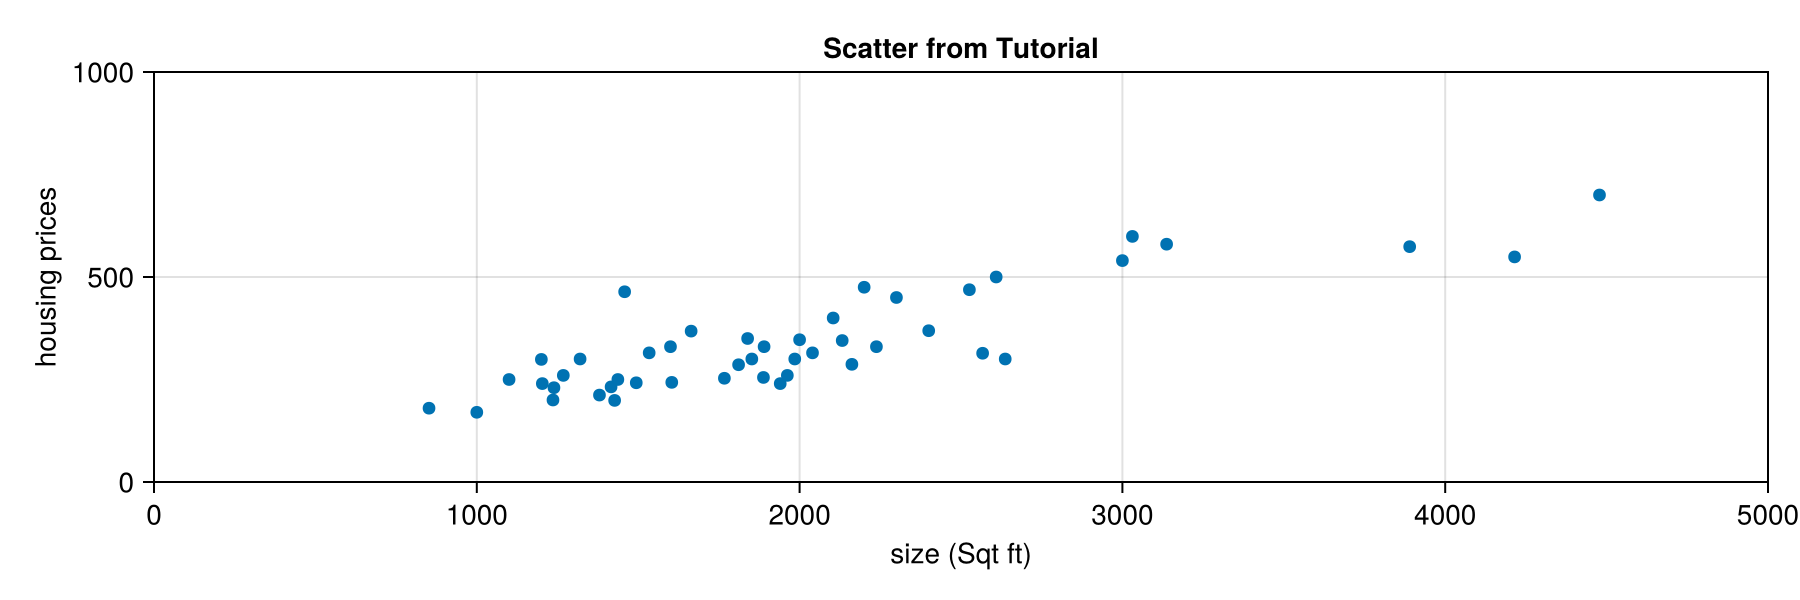

In [45]:
fig = Figure(; size = (900,300))
ax = Axis(fig[1,1];
    xlabel="size (Sqt ft)",
    ylabel="housing prices",
    title="Scatter from Tutorial"
    )
CairoMakie.ylims!(ax, (0, 1000))
CairoMakie.xlims!(ax, (0, 5000))
#scatter!(numsA,numPosA,color=1:20,colormap=:tab20)
#scatter!(numsB,numPosB,color=1:20,colormap=:tab20, markersize = 15)
scatter!(X, Y)
fig

In [50]:
ols = lm(@formula(Y ~ X), t)

    lines!(X, predict(ols), color = :green)

    newX = Table(X = [1250])

    predict(ols, newX)

1-element Vector{Union{Missing, Float64}}:
 239.4556726896737

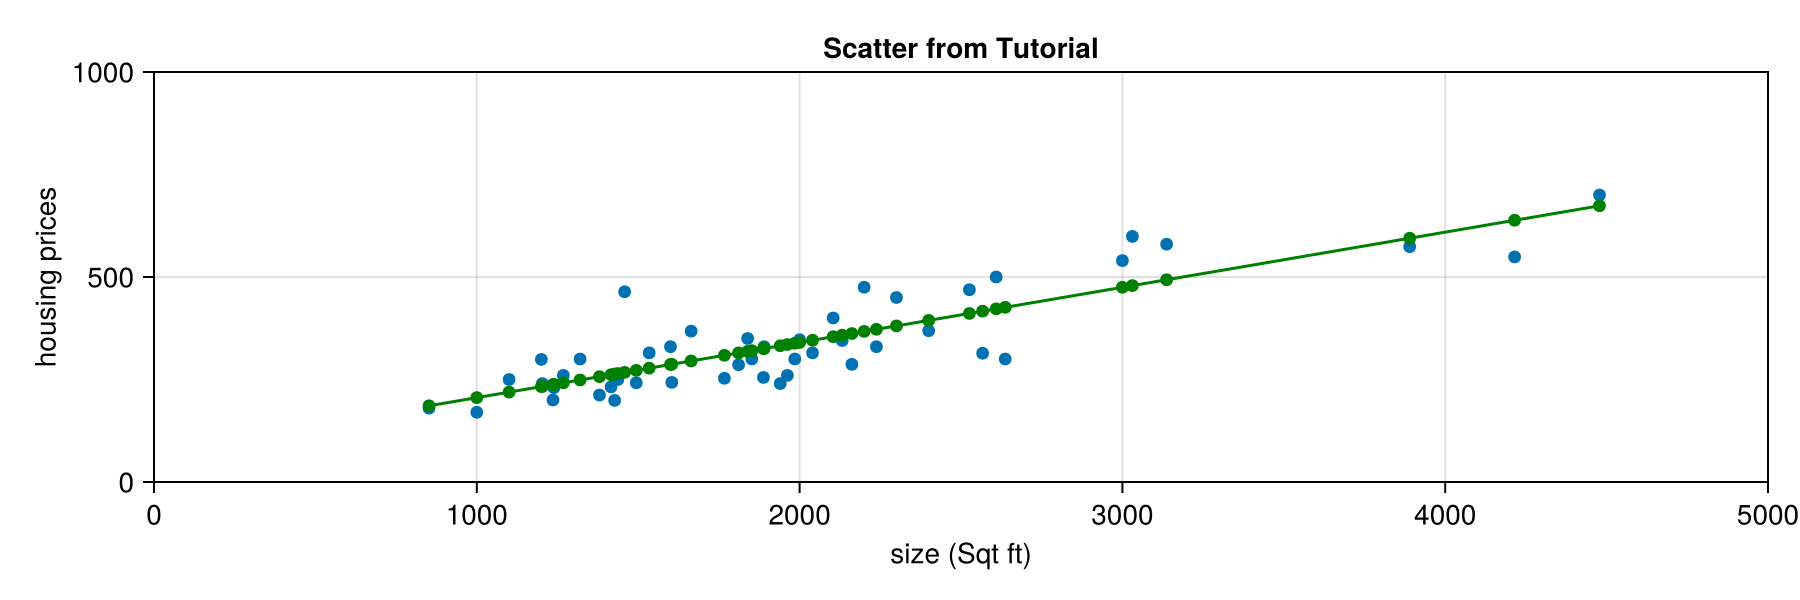

In [51]:
fig

In [49]:
ols = lm(@formula(Y ~ X), t)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  71.2898    26.1331      2.73    0.0091  18.655     123.925
X             0.134533   0.0121571  11.07    <1e-13   0.110047    0.159018
──────────────────────────────────────────────────────────────────────────

In [52]:
X

47-element Vector{Int64}:
 2104
 1600
 2400
 1416
 3000
 1985
 1534
 1427
 1380
 1494
 1940
 2000
 1890
    ⋮
 1437
 1239
 2132
 4215
 2162
 1664
 2238
 2567
 1200
  852
 1852
 1203

In [53]:
Y

47-element Vector{Int64}:
 400
 330
 369
 232
 540
 300
 315
 199
 212
 242
 240
 347
 330
   ⋮
 250
 230
 345
 549
 287
 368
 330
 314
 299
 180
 300
 240

In [54]:
t

Table with 2 columns and 47 rows:
      X     Y
    ┌──────────
 1  │ 2104  400
 2  │ 1600  330
 3  │ 2400  369
 4  │ 1416  232
 5  │ 3000  540
 6  │ 1985  300
 7  │ 1534  315
 8  │ 1427  199
 9  │ 1380  212
 10 │ 1494  242
 11 │ 1940  240
 12 │ 2000  347
 13 │ 1890  330
 14 │ 4478  700
 15 │ 1268  260
 16 │ 2300  450
 17 │ 1320  300
 18 │ 1236  200
 19 │ 2609  500
 20 │ 3031  599
 21 │ 1767  253
 22 │ 1888  255
 23 │ 1604  243
 ⋮  │  ⋮     ⋮

In [51]:
35*7

245